In [1]:
import os, io, sys, platform, warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch, torchvision
from torchvision import transforms

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("Platform:", platform.platform())

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Thiết bị:", device)

Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
PyTorch: 2.9.0+cpu
TorchVision: 0.24.0+cpu
Platform: Windows-11-10.0.26200-SP0
Thiết bị: cpu


In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def load_image(path_or_url, to_rgb=True):
    try:
        if str(path_or_url).startswith(("http://","https://")):
            resp = requests.get(path_or_url, timeout=15)
            resp.raise_for_status()
            img = Image.open(io.BytesIO(resp.content))
        else:
            img = Image.open(path_or_url)
    except Exception as e:
        print("Không thể tải ảnh:", e)
        raise
    if to_rgb and img.mode != "RGB":
        img = img.convert("RGB")
    return img

def show_image(img, title=None):
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

def preprocess_imagenet(img_pil, size=224):
    tfm = transforms.Compose([
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    return tfm(img_pil).unsqueeze(0)

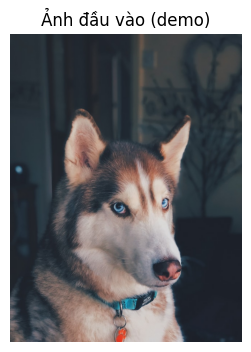

In [3]:
IMG_PATH = r"D:\năm 4\PythonSGU\BaiTap+BaiGiangML\BaiTap\img\dog_alaska.jpg"

img_source = IMG_PATH
img = load_image(img_source, to_rgb=True)
show_image(img, "Ảnh đầu vào (demo)")

# EfficientNet — Phân loại ảnh (compound scaling).

In [5]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

try:
    weights = EfficientNet_B0_Weights.DEFAULT
    categories = weights.meta.get("categories", None)
    model_eff = efficientnet_b0(weights=weights).to(device).eval()
    print("Đã tải EfficientNet-B0 pretrained.")
except Exception as e:
    print("Không tải được trọng số EfficientNet-B0, dùng random init:", e)
    model_eff = efficientnet_b0(weights=None).to(device).eval()
    categories = None

x = preprocess_imagenet(img, size=224).to(device)
with torch.no_grad():
    logits = model_eff(x)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

top5_idx = np.argsort(-probs)[:5]
print("Top-5 (EfficientNet-B0):")
for i in top5_idx:
    label = categories[i] if categories else f"class_{i}"
    print(f"  {label:25s} prob={probs[i]:.4f}")


Đã tải EfficientNet-B0 pretrained.
Top-5 (EfficientNet-B0):
  Siberian husky            prob=0.5881
  Eskimo dog                prob=0.3595
  malamute                  prob=0.0057
  timber wolf               prob=0.0009
  dogsled                   prob=0.0008
